# Simulated toy example

In [1]:
from bhad.utils import Discretize, mvt2mixture
from bhad.model import BHAD
import numpy as np
import matplotlib.pyplot as plt
#from importlib import reload

### Draw from a two-component multivariate Student-t mixture distribution

Note: Anomaly class corresponds to the minority mixture component

In [38]:
seed = 42  
outlier_prob_true = .01         # probab. for outlier ; should be consistent with contamination rate in your model
k = 500                          # feature dimension 
N = 10**4                     # sample size

# Specify first and second moments for each component  
bvt = mvt2mixture(thetas = {'mean1' : np.full(k,-1), 'mean2' : np.full(k,.5), 
                                'Sigma1' : np.eye(k)*.4, 'Sigma2' : np.eye(k)*.1, 
                                'nu1': 3.*k, 'nu2': 3.*k}, seed = seed, gaussian = False)

# Get latent draws and observations:
#------------------------------------
y_true, dataset = bvt.draw(n_samples = N, k = k, p = outlier_prob_true)

print(dataset.shape)

(10000, 500)


In [39]:
y_true.mean()    # probab. latent class 1 (=anomaly)

0.0098

### Visualize the data:

Reduce dimension for visualization only:

In [40]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(dataset)

X_reduce = TruncatedSVD(n_components=3).fit_transform(X)

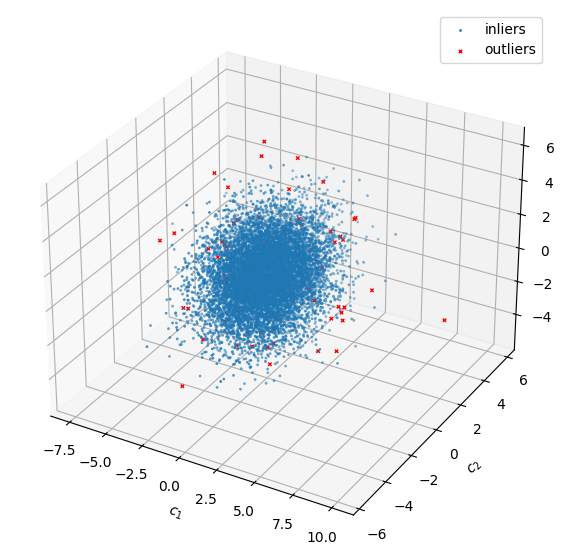

In [41]:
# Plot all the ground truth points together with the predictions

fig = plt.figure(figsize=(10,7))
#ax = plt.axes()
ax = fig.add_subplot(111, projection='3d')
#plt.title("Compressed data set")
ax.set_xlabel(r'$c_{1}$') ; ax.set_ylabel(r'$c_{2}$') ;ax.set_zlabel(r'$c_{3}$')

# Plot the compressed inliers data points
ax.scatter(X_reduce[y_true == 0, 0], X_reduce[y_true == 0, 1], zs=X_reduce[y_true == 0, 2], s=4, lw=0, label = "inliers")

# outliers
ax.scatter(X_reduce[y_true == 1, 0], X_reduce[y_true == 1, 1], zs=X_reduce[y_true == 1, 2], 
           lw=1, s=6, marker="x", c="red", alpha=1, label = "outliers")
ax.legend()
#fig.savefig('mixturePlot3D.png')   # save the figure to file
plt.show();
#plt.close(fig);    # close the figure window

Partition dataset:

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, y_true, test_size=0.33, random_state=42)

print(X_train.shape)
print(X_test.shape)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(6700, 500)
(3300, 500)
(array([0, 1]), array([6637,   63]))
(array([0, 1]), array([3265,   35]))


For comparison:

In [43]:
#from sklearn.ensemble import IsolationForest

#clf = IsolationForest(random_state=0).fit(X_train)

#y_pred_train = clf.predict(X_train)
#y_pred_test = clf.predict(X_test)

### Model training and prediction

In [44]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    ('discrete' , Discretize(nbins = None, verbose = True)),      # step only needed if continous features are present
    ('model', BHAD(contamination = 0.01))
])

y_pred_train = pipe.fit_predict(X_train)
scores_train = pipe.decision_function(X_train)


-- Bayesian Histogram-based Anomaly Detector (BHAD) --

Setting maximum number of bins 82.
Resetting index of input dataframe.
Input shape: (6700, 500)
Used 500 numeric feature(s) and 0 categorical feature(s).
Determining optimal number of bins for numeric features
Feature var0 using 22 bins
Determining optimal number of bins for numeric features
Feature var1 using 25 bins
Determining optimal number of bins for numeric features
Feature var2 using 27 bins
Determining optimal number of bins for numeric features
Feature var3 using 25 bins
Determining optimal number of bins for numeric features
Feature var4 using 32 bins
Determining optimal number of bins for numeric features
Feature var5 using 20 bins
Determining optimal number of bins for numeric features
Feature var6 using 24 bins
Determining optimal number of bins for numeric features
Feature var7 using 21 bins
Determining optimal number of bins for numeric features
Feature var8 using 30 bins
Determining optimal number of bins for num

In [45]:
y_pred_test = pipe.predict(X_test)
scores_test = pipe.decision_function(X_test)

Reseting index of input dataframe.

Score input data.
Apply fitted one-hot encoder.

Score input data.
Apply fitted one-hot encoder.


Plot score distribution:

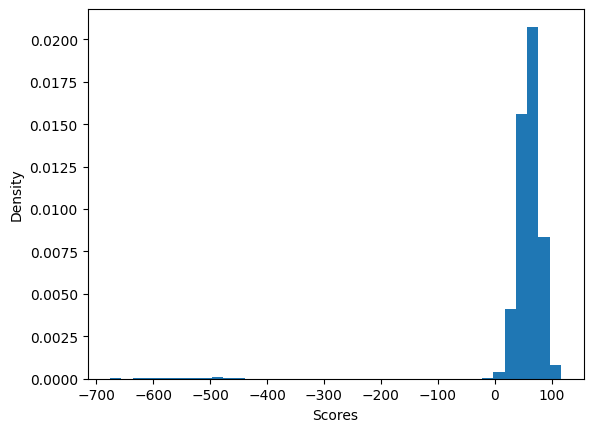

In [46]:
plt.hist(scores_train, density=True, bins=40) 
plt.ylabel('Density')
plt.xlabel('Scores');

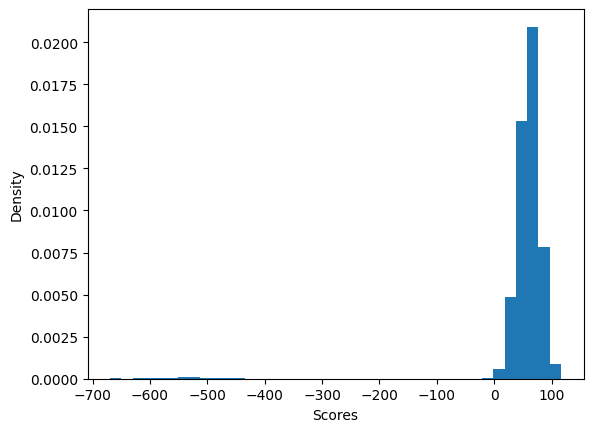

In [47]:
plt.hist(scores_test, density=True, bins=40) 
plt.ylabel('Density')
plt.xlabel('Scores');

In [48]:
from sklearn.metrics import classification_report

# Make comparable to y_true encoding
y_pred_train[y_pred_train == 1] = 0
y_pred_train[y_pred_train == -1] = 1

print(classification_report(y_train, y_pred_train, target_names=['Inlier', 'Outlier']))

              precision    recall  f1-score   support

      Inlier       1.00      1.00      1.00      6637
     Outlier       0.94      1.00      0.97        63

    accuracy                           1.00      6700
   macro avg       0.97      1.00      0.98      6700
weighted avg       1.00      1.00      1.00      6700



In [49]:
# Make comparable to y_true encoding
y_pred_test[y_pred_test == 1] = 0
y_pred_test[y_pred_test == -1] = 1

print(classification_report(y_test, y_pred_test, target_names=['Inlier', 'Outlier']))

              precision    recall  f1-score   support

      Inlier       1.00      1.00      1.00      3265
     Outlier       0.92      1.00      0.96        35

    accuracy                           1.00      3300
   macro avg       0.96      1.00      0.98      3300
weighted avg       1.00      1.00      1.00      3300



## Model explanation:

Retrieve local model explanations. Here: Specify all numeric and categorical columns explicitly

In [14]:
num_cols = list(X_train.select_dtypes(include=['float', 'int']).columns) 
cat_cols = list(X_train.select_dtypes(include=['object', 'category']).columns)

In [15]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    ('discrete', Discretize(nbins = None, verbose = True)),     
    ('model', BHAD(contamination = 0.01, num_features = num_cols, cat_features = cat_cols))
])

y_pred_train = pipe.fit_predict(X_train)


-- Bayesian Histogram-based Anomaly Detector (BHAD) --

Setting maximum number of bins 184.
Input shape: (33500, 30)
Used 30 numeric feature(s) and 0 categorical feature(s).
Determining optimal number of bins for numeric features
Feature var0 using 49 bins
Determining optimal number of bins for numeric features
Feature var1 using 61 bins
Determining optimal number of bins for numeric features
Feature var2 using 42 bins
Determining optimal number of bins for numeric features
Feature var3 using 52 bins
Determining optimal number of bins for numeric features
Feature var4 using 46 bins
Determining optimal number of bins for numeric features
Feature var5 using 51 bins
Determining optimal number of bins for numeric features
Feature var6 using 51 bins
Determining optimal number of bins for numeric features
Feature var7 using 51 bins
Determining optimal number of bins for numeric features
Feature var8 using 55 bins
Determining optimal number of bins for numeric features
Feature var9 using 57 

In [16]:
from bhad import explainer

local_expl = explainer.Explainer(pipe.named_steps['model'], pipe.named_steps['discrete']).fit()

--- BHAD Model Explainer ---

Using fitted BHAD and discretizer.
Marginal distributions estimated using train set of shape (33500, 30)


In [17]:
df_train = local_expl.get_explanation(append = False)

df_train.head(5)

Create local explanations for 33500 observations.


  0%|          | 0/33500 [00:00<?, ?it/s]

0                      var0 (Cumul.perc.: 0.964): 6.34
1    var5 (Cumul.perc.: 0.016): -6.17\nvar18 (Cumul...
2    var17 (Cumul.perc.: 0.998): 9.28\nvar22 (Cumul...
3    var12 (Cumul.perc.: 0.989): 6.62\nvar28 (Cumul...
4    var23 (Cumul.perc.: 0.053): -4.69\nvar1 (Cumul...
Name: explanation, dtype: object

In [18]:
global_feat_imp = local_expl.global_feat_imp         # based on X_train

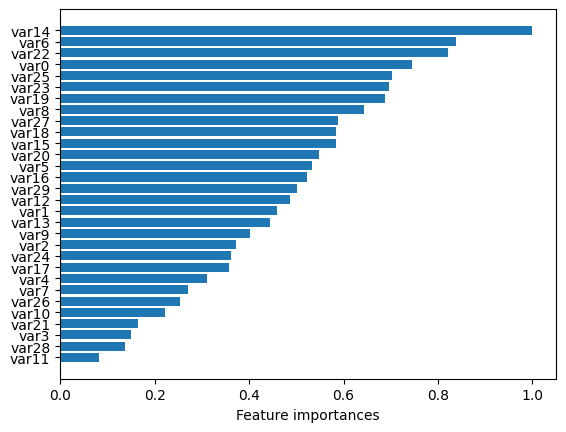

In [19]:
from matplotlib import pyplot as plt

plt.barh(global_feat_imp.index, global_feat_imp.values.flatten())
plt.xlabel("Feature importances");

#plt.savefig('global_importances.png')   # save the figure to file
plt.show();
plt.close();    # close the figure window

In [20]:
y_pred_test = pipe.predict(X_test)


Score input data.
Apply fitted one-hot encoder.


In [21]:
df_test = local_expl.get_explanation(thresholds = [.1]*X_test.shape[1])  # make threshold more conservative (only more extreme values are considered as outliers)

Create local explanations for 16500 observations.
Using custom thresholds.


  0%|          | 0/16500 [00:00<?, ?it/s]

In [22]:
for obs, ex in enumerate(df_test.explanation.values):
    if (obs % 10) == 0:
        print(f'\nObs. {obs}:\n', ex)


Obs. 0:
 var26 (Cumul.perc.: 0.002): -8.44
var4 (Cumul.perc.: 0.021): -5.5
var8 (Cumul.perc.: 0.025): -4.79
var29 (Cumul.perc.: 0.028): -5.66
var25 (Cumul.perc.: 0.952): 5.58

Obs. 10:
 var26 (Cumul.perc.: 0.999): 10.05
var16 (Cumul.perc.: 0.966): 5.64
var5 (Cumul.perc.: 0.953): 5.65

Obs. 20:
 var12 (Cumul.perc.: 0.997): 7.92
var18 (Cumul.perc.: 0.964): 6.13

Obs. 30:
 var15 (Cumul.perc.: 0.97): 5.77
var9 (Cumul.perc.: 0.031): -4.28
var29 (Cumul.perc.: 0.044): -4.96
var22 (Cumul.perc.: 0.048): -4.37

Obs. 40:
 var29 (Cumul.perc.: 0.014): -6.62
var3 (Cumul.perc.: 0.016): -5.43

Obs. 50:
 var17 (Cumul.perc.: 0.967): 5.87
var5 (Cumul.perc.: 0.049): -4.64

Obs. 60:
 var8 (Cumul.perc.: 0.017): -5.34
var20 (Cumul.perc.: 0.035): -4.42
var16 (Cumul.perc.: 0.96): 5.45

Obs. 70:
 var25 (Cumul.perc.: 0.988): 7.5
var15 (Cumul.perc.: 0.981): 6.45

Obs. 80:
 var21 (Cumul.perc.: 0.979): 7.25
var13 (Cumul.perc.: 0.036): -5.41
var22 (Cumul.perc.: 0.959): 5.61

Obs. 90:
 var19 (Cumul.perc.: 0.01): -6.